<a href="https://colab.research.google.com/github/WittmannF/deepfeatx/blob/master/examples/mask_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installations and Downloads

In [ ]:
# https://drive.google.com/file/d/1IqDRGWstRDqg9QdQhcrK7i65Yu02W21_/view
!gdown --id 1IqDRGWstRDqg9QdQhcrK7i65Yu02W21_

Downloading...
From: https://drive.google.com/uc?id=1IqDRGWstRDqg9QdQhcrK7i65Yu02W21_
To: /content/data.zip
378MB [00:02, 160MB/s]


In [ ]:
!pip install deepfeatx --quiet

In [ ]:
!unzip data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data/pictures/without_mask/image_48.png  
  inflating: __MACOSX/data/pictures/without_mask/._image_48.png  
  inflating: data/pictures/without_mask/without_mask_2607.jpg  
  inflating: __MACOSX/data/pictures/without_mask/._without_mask_2607.jpg  
  inflating: data/pictures/without_mask/without_mask_225.jpg  
  inflating: __MACOSX/data/pictures/without_mask/._without_mask_225.jpg  
  inflating: data/pictures/without_mask/without_mask_3519.jpg  
  inflating: __MACOSX/data/pictures/without_mask/._without_mask_3519.jpg  
  inflating: data/pictures/without_mask/image_60.png  
  inflating: __MACOSX/data/pictures/without_mask/._image_60.png  
  inflating: data/pictures/without_mask/without_mask_1326.jpg  
  inflating: __MACOSX/data/pictures/without_mask/._without_mask_1326.jpg  
  inflating: data/pictures/without_mask/without_mask_3531.jpg  
  inflating: __MACOSX/data/pictures/without_mask/._without_mask_3531.jpg  
  inflating: d

## Modeling

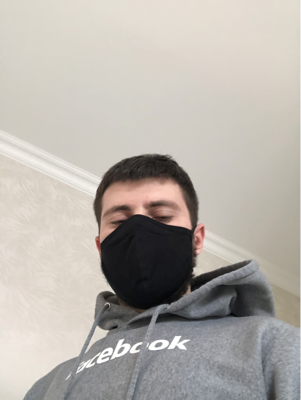

In [ ]:
import glob
from PIL import Image
import random
with_mask_list = glob.glob('/content/data/pictures/with_mask/*.png')
Image.open(random.choice(with_mask_list))

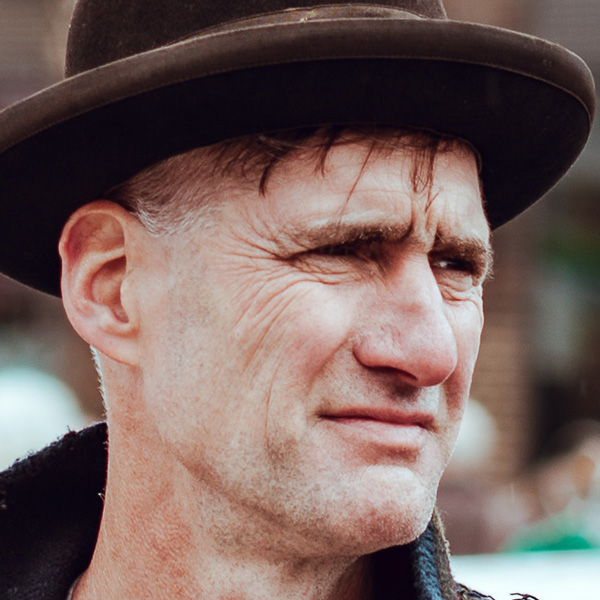

In [ ]:
without_mask_list = glob.glob('/content/data/pictures/without_mask/*.png')
Image.open(random.choice(without_mask_list))

In [ ]:
from deepfeatx.image import ImageFeatureExtractor
from sklearn.linear_model import LogisticRegression

In [ ]:
fe = ImageFeatureExtractor()
data=fe.extract_features_from_directory('/content/data/pictures', 
                                         classes_as_folders=True,
                                         export_class_names=True)

94773248/94765736 [==============================] - 1s 0us/step
Found 7993 images belonging to 2 classes.
 81/250 [========>.....................] - ETA: 24s

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


250/250 [==============================] - 73s 157ms/step


In [ ]:
data.head()

,filepaths,classes,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,/content/data/pictures/with_mask/image_0.png,with_mask,0.038728,0.884569,0.145154,0.289122,0.159535,0.302129,0.799904,0.624662,0.000000,0.536665,0.000000,0.124027,0.014848,0.218987,0.182428,0.701481,0.000000,0.003364,0.456969,0.081808,0.067931,4.386366,0.011628,0.906452,0.023253,0.133682,0.000000,0.321479,0.000000,0.108322,0.029827,0.777090,0.023752,0.189514,1.215714,1.091062,0.690735,0.174089,...,0.339069,0.149166,0.247207,0.775106,0.900573,0.355789,0.718435,0.014150,0.004027,0.154377,0.689587,0.010095,0.364866,0.000126,0.004005,0.001322,0.562173,0.394833,0.118522,0.298971,0.009222,0.179920,0.000136,0.228557,0.140571,0.065109,0.055527,0.187462,0.871076,2.080384,0.016262,0.404929,0.062483,0.140095,0.037467,0.039644,0.000000,0.000806,0.000000,0.301592
1,/content/data/pictures/with_mask/image_1.png,with_mask,0.754308,0.528980,0.012559,0.062728,0.000000,0.000000,0.027178,0.392129,0.105666,2.254386,3.669291,0.867388,1.217090,0.091142,0.907778,0.370730,0.302327,0.587381,1.946053,0.002851,0.052934,0.214102,0.322849,2.277998,0.156311,0.748763,0.027606,2.217844,0.165846,1.808477,0.611897,0.760043,0.033616,0.349566,0.150578,0.324043,0.606515,0.192061,...,0.879131,0.297444,1.090990,0.066868,0.601436,0.119779,0.611670,0.005616,0.187576,0.000000,0.715240,2.140784,0.074463,0.000000,0.149693,0.107843,0.000000,0.024266,0.095110,0.101664,0.108711,0.182068,0.831864,0.695754,0.608610,0.708761,0.843659,0.358284,0.508741,0.035592,0.454394,0.000000,1.435937,0.006064,0.234883,0.139632,0.060959,0.108313,0.454268,0.025377
2,/content/data/pictures/with_mask/image_10.png,with_mask,0.197473,1.517343,1.466243,1.681325,0.050286,0.546829,0.374659,0.527167,1.284535,0.390844,1.110771,0.281559,0.699328,0.055652,0.197109,0.827601,0.242554,0.341361,0.838305,0.046601,0.803699,2.945499,0.236529,0.933820,0.364316,0.160227,0.501455,0.370828,0.101750,0.264981,0.055136,0.400271,0.140755,0.551762,0.255219,1.017878,1.070643,2.420804,...,0.390633,0.483882,0.063060,0.024577,0.541017,0.087207,0.135612,0.176237,0.372269,0.058101,0.197528,0.388002,0.914873,0.307844,0.010666,0.007693,0.374087,0.835616,0.225133,0.035382,1.396633,0.410353,0.492077,0.026497,0.185682,0.231604,0.467451,0.000000,0.545197,0.163750,0.210841,1.517009,0.726423,0.375914,0.090221,1.045121,0.000000,0.591376,0.143809,0.473014
3,/content/data/pictures/with_mask/image_100.png,with_mask,0.798184,0.596341,0.116794,0.297159,0.188628,0.217078,0.025765,0.372647,0.110953,0.120063,1.323061,0.000000,0.099937,0.178319,0.788991,0.173998,0.005253,0.539341,0.311607,0.115506,2.249337,1.111959,0.029067,0.683579,0.075254,0.518561,0.078177,0.276534,0.090848,0.313089,0.128852,2.282389,0.323765,1.870573,0.913400,0.006153,0.532217,0.300853,...,0.509243,0.305444,0.302291,0.027365,0.001218,0.200142,0.000000,0.327191,0.627201,0.066116,0.157595,0.999762,0.013625,0.000000,1.712726,0.569567,1.057799,0.013006,0.288061,1.780884,0.422846,1.228936,0.300682,0.089792,2.613131,0.075552,0.259096,0.049631,0.000000,0.000000,0.419835,0.341016,0.635663,0.585333,0.160090,0.000000,0.073669,0.037409,0.180549,0.793652
4,/content/data/pictures/with_mask/image_101.png,with_mask,0.072735,0.745069,0.216335,0.683348,0.090898,0.264745,0.090746,0.055044,0.088695,0.157139,1.389155,0.275102,0.176964,0.106504,0.622202,0.206308,0.014517,0.030691,0.091511,0.029294,0.930170,1.109624,0.175624,1.517424,0.379228,0.029312,0.003013,1.615559,0.175488,0.070150,0.048155,0.055575,0.857557,0.468785,2.156053,1.321780,0.439413,0.714342,...,0.190821,0.404355,0.904895,1.627531,0.158723,0.369290,0.011871,0.120792,0.458565,1.766821,0.301147,1.063183,0.000000,0.244074,0.029429,0.135282,0.088552,0.061993,0.599151,0.314201,0.001926,0.465264,0.000000,0.0410

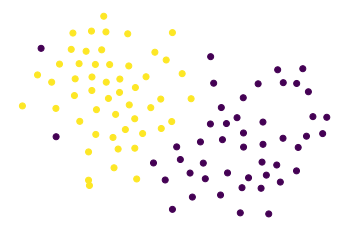

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

def project_2d(df, labels):
    reduced_data = TSNE(n_components=2).fit_transform(df)
    # Create a DataFrame for the reduced data
    reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])
    plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'], c=labels)
    plt.axis('off')
    plt.show()

labels_array, idx_to_class = data.classes.factorize()
sample_idx = data.sample(100).index
project_2d(data.drop(['filepaths','classes'], axis=1).iloc[sample_idx], labels_array[sample_idx])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import seaborn as sns

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['filepaths','classes'], axis=1), 
    labels_array, 
    test_size=0.25, 
    random_state=42
)

lr = LogisticRegression().fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1])

0.999777757755954

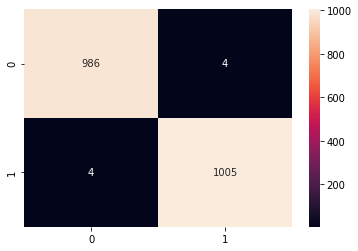

In [ ]:
import seaborn as sns
cm=confusion_matrix(y_test, lr.predict(X_test))
sns.heatmap(cm, annot=True, fmt='g')

## Exporting model

In [ ]:
import pickle
pickle.dump(lr, open('logistic_regression.pkl', 'wb'))

In [ ]:
pickle.dump(idx_to_class, open('idx_to_class.pkl', 'wb'))

## Deploy

In [ ]:
!pip install deepfeatx --quiet

In [ ]:
!pip install gradio --quiet

     |████████████████████████████████| 1.1MB 8.0MB/s 
     |████████████████████████████████| 215kB 50.1MB/s 
     |████████████████████████████████| 1.9MB 38.6MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
     |████████████████████████████████| 962kB 39.6MB/s 
     |████████████████████████████████| 3.2MB 48.0MB/s 


In [ ]:
lr=pickle.load(open('logistic_regression.pkl', 'rb'))

In [ ]:
idx_to_class=pickle.load(open('idx_to_class.pkl', 'rb'))

In [ ]:
from deepfeatx.image import ImageFeatureExtractor
from PIL import Image

In [ ]:
fe = ImageFeatureExtractor()

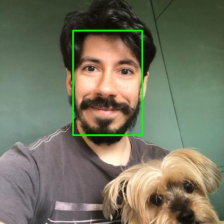

In [ ]:
url = 'https://miro.medium.com/max/481/1*ghH-5iPRFbOE6MsiI-LvEw.jpeg'
fe.read_img_url(url)

In [ ]:
vector = fe.url_to_vector(url)
probas = lr.predict_proba(vector)[0]
idx = probas.argmax()

predicted_class=idx_to_class[idx]
predicted_confidence = probas[idx]

print(f'Predicted class: {predicted_class}')
print(f'Predicted confidence {predicted_confidence*100:.2f}%')

Predicted class: without_mask
Predicted confidence 99.99%


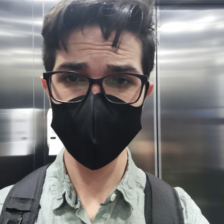

In [ ]:
url = 'https://user-images.githubusercontent.com/5733246/117880608-b0658a00-b27e-11eb-91ca-0bb0479b38fb.jpg'
fe.read_img_url(url)

In [ ]:
vector = fe.url_to_vector(url)
probas = lr.predict_proba(vector)[0]
idx = probas.argmax()

predicted_class=idx_to_class[idx]
predicted_confidence = probas[idx]

print(f'Predicted class: {predicted_class}')
print(f'Predicted confidence {predicted_confidence*100:.2f}%')

Predicted class: with_mask
Predicted confidence 100.00%


In [ ]:
import gradio as gr
import numpy as np
from PIL import Image

def mask_detector(img):
    # ... implement face segmentation model on input 200x200 numpy array
    img = Image.fromarray(img)
    vector = fe.img_to_vector(img)
    probas = lr.predict_proba(vector)[0]
    idx = probas.argmax()

    predicted_class=idx_to_class[idx]
    predicted_confidence = probas[idx]

    return f'Predicted class: {predicted_class}, Predicted confidence {predicted_confidence*100:.2f}%'



In [ ]:
webcam = gr.inputs.Image(shape=(224, 224), source="webcam")
gr.Interface(fn=mask_detector, inputs=webcam, outputs="text").launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
This share link will expire in 24 hours. If you need a permanent link, visit: https://gradio.app/introducing-hosted (NEW!)
Running on External URL: https://34254.gradio.app
Interface loading below...


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://34254.gradio.app')

In [ ]:
pip freeze

absl-py==0.12.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
analytics-python==1.3.1
appdirs==1.4.4
argon2-cffi==20.1.0
arviz==0.11.2
astor==0.8.1
astropy==4.2.1
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==21.2.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
backoff==1.10.0
bcrypt==3.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.3.2
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.2
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
cftime==1.4.1
chainer==7.4.0
chardet==3.0.4
click==8.0.0
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==2.0.6
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.2
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cryptography==3.4.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.23
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
deepfeat